# **TensorFlow Image Classifier**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D,Flatten
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train = tfds.load('mnist', split='train',batch_size=64)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
def preprocess_image(input):
  image = input['image']
  label = input['label']
  image = tf.cast(image,tf.float32)/255.
  return image,label

train = train.map(preprocess_image)

In [4]:
train_ds = train.take(750)
test_ds = train.skip(750)
val_ds = test_ds.take(93)
test_ds = test_ds.skip(93)

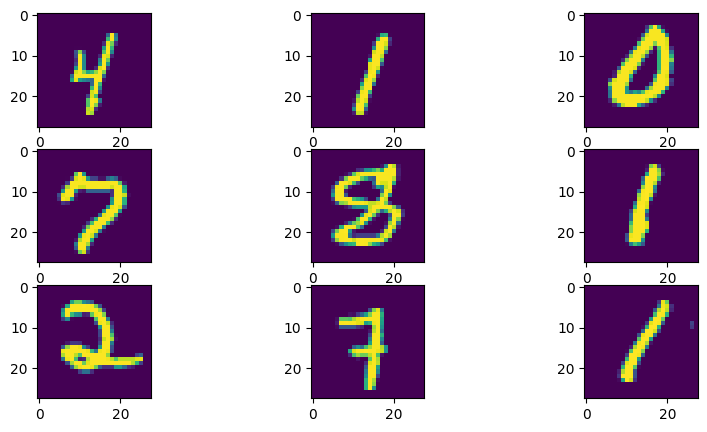

In [5]:
plt.figure(figsize=(10,5))
for image,label in train_ds.take(1):
  for i  in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(np.squeeze(image[i].numpy()))


In [11]:
class Tensorflow_Image_Classifier(tf.keras.Model):
  def __init__(self):
    super().__init__()

    self.conv1 = Conv2D(16,kernel_size=(3,3),padding='same',activation='relu',input_shape=(28,28,1))
    self.flatten = Flatten()
    self.dense1  = Dense(32,activation='relu')
    self.dense2  = Dense(16,activation='relu')
    self.dense3  = Dense(10, activation='softmax')

  def call(self,inputs):
    conv1 = self.conv1(inputs)
    flatten = self.flatten(conv1)
    dense1 = self.dense1(flatten)
    dense2 = self.dense2(dense1)
    return self.dense3(dense2)

In [12]:
model = Tensorflow_Image_Classifier()

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [14]:
@tf.function
def training_model(image,y_true):
  with tf.GradientTape() as tape:
    y_pred = model(image)
    loss = loss_object(y_true=y_true,y_pred=y_pred)

  grad = tape.gradient(loss,model.trainable_variables)
  optimizer.apply_gradients(zip(grad,model.trainable_variables))
  return y_pred, loss

In [15]:
losses=[]
per_epoch_loss=[]
for i in range(40):
  print(f'Epoch= {i+1}/40')
  for image,y_true in train_ds:
    y_true = y_true.numpy().reshape(-1,1)
    y_pred, loss = training_model(image,y_true)
    losses.append(loss)
  per_epoch_loss.append(np.mean(losses))
  print(f'Epoch= {i+1} , Loss={np.mean(losses)}')

Epoch= 1/40
Epoch= 1 , Loss=0.3386983871459961
Epoch= 2/40
Epoch= 2 , Loss=0.21968106925487518
Epoch= 3/40
Epoch= 3 , Loss=0.1679069846868515
Epoch= 4/40
Epoch= 4 , Loss=0.13729509711265564
Epoch= 5/40
Epoch= 5 , Loss=0.11653921008110046
Epoch= 6/40
Epoch= 6 , Loss=0.10105249285697937
Epoch= 7/40
Epoch= 7 , Loss=0.08922529965639114
Epoch= 8/40
Epoch= 8 , Loss=0.07999864220619202
Epoch= 9/40
Epoch= 9 , Loss=0.07275990396738052
Epoch= 10/40
Epoch= 10 , Loss=0.06677122414112091
Epoch= 11/40
Epoch= 11 , Loss=0.061602819710969925
Epoch= 12/40
Epoch= 12 , Loss=0.05706479400396347
Epoch= 13/40
Epoch= 13 , Loss=0.053122419863939285
Epoch= 14/40
Epoch= 14 , Loss=0.0496944934129715
Epoch= 15/40
Epoch= 15 , Loss=0.046788472682237625
Epoch= 16/40
Epoch= 16 , Loss=0.04428490251302719
Epoch= 17/40
Epoch= 17 , Loss=0.042006056755781174
Epoch= 18/40
Epoch= 18 , Loss=0.03990664333105087
Epoch= 19/40
Epoch= 19 , Loss=0.038141995668411255
Epoch= 20/40
Epoch= 20 , Loss=0.0365295484662056
Epoch= 21/40
Epoc

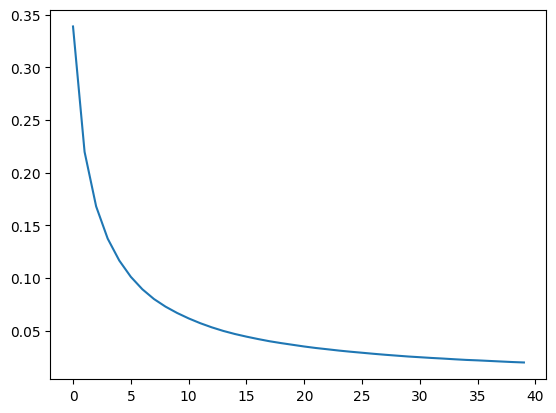

In [16]:
plt.plot(range(40),per_epoch_loss)

# **Pytorch Image Classifier**

In [47]:
from torch import nn
from torch.nn import Conv2d,Linear,Flatten
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


In [48]:
train = datasets.MNIST(root='data',train=True,download=True,transform=ToTensor())

In [49]:
train_ds = DataLoader(train,64)

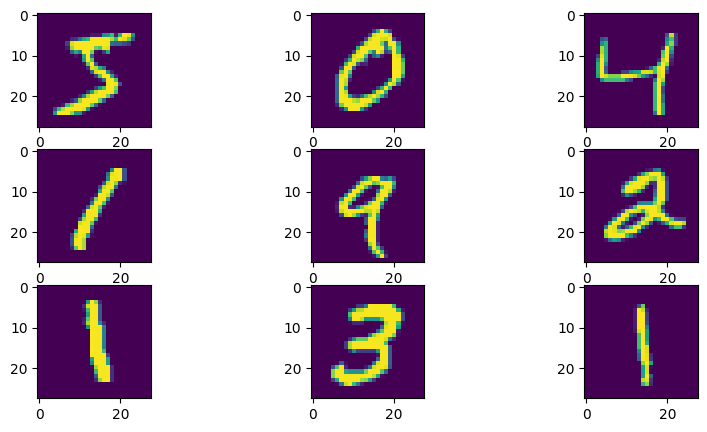

In [59]:
plt.figure(figsize=(10,5))
for data in train_ds:
  for i  in range(9):
    image,label = data
    plt.subplot(3,3,i+1)
    plt.imshow(np.squeeze(image[i].numpy()))
  break

In [50]:
class Torch_Image_Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1,16,(3,3))
    self.relu = nn.ReLU()
    self.flatten = Flatten()
    self.linear1  = Linear(16*(28-2)*(28-2),32)
    self.linear2  = Linear(32,16)
    self.linear3  = Linear(16,10)

  def forward(self,inputs):
    conv1 = self.conv1(inputs)
    conv1 = self.relu(conv1)
    flatten = self.flatten(conv1)
    linear1 = self.linear1(flatten)
    linear1 = self.relu(linear1)
    linear2 = self.linear2(linear1)
    linear2 = self.relu(linear2)
    return self.linear3(linear2)

In [51]:
torch_model = Torch_Image_Classifier().to('cuda')

In [52]:
optimizer = Adam(lr=1e-3,params=torch_model.parameters())
loss_object = nn.CrossEntropyLoss()

In [54]:
per_epoch_loss=[]
for i in range(10):
  print(f'Epoch= {i+1}/10')
  for data in train_ds:
    image,y_true = data
    image = image.to('cuda')
    y_true =y_true.to("cuda")

    y_pred = torch_model(image)

    loss = loss_object(y_pred,y_true)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'Epoch= {i+1} , loss= {loss.item()}')
  per_epoch_loss.append(loss.item())

Epoch= 1/10
Epoch= 1 , loss= 0.10755209624767303
Epoch= 2/10
Epoch= 2 , loss= 0.039781346917152405
Epoch= 3/10
Epoch= 3 , loss= 0.01348559744656086
Epoch= 4/10
Epoch= 4 , loss= 0.009216876700520515
Epoch= 5/10
Epoch= 5 , loss= 0.003445067908614874
Epoch= 6/10
Epoch= 6 , loss= 0.0016460876213386655
Epoch= 7/10
Epoch= 7 , loss= 0.002761883893981576
Epoch= 8/10
Epoch= 8 , loss= 0.0011515830410644412
Epoch= 9/10
Epoch= 9 , loss= 0.0004779806768056005
Epoch= 10/10
Epoch= 10 , loss= 0.0004916887264698744


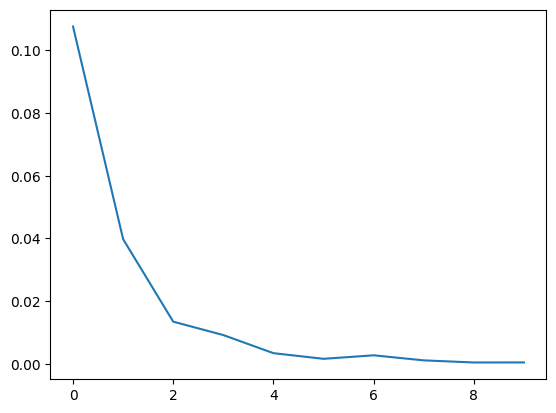

In [61]:
plt.plot(range(10),per_epoch_loss)